<a href="https://colab.research.google.com/github/SimoneDutto/Hate-Speech-TwitterBot/blob/master/HateSpeech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tesina Data Spaces
Considerazioni: stopword, lemmatize, hashtag, multinaive, logistic regression, grammar error
https://towardsdatascience.com/detecting-hate-tweets-twitter-sentiment-analysis-780d8a82d4f6 
https://pypi.org/project/grammar-check/

### Import Dataset

In [7]:
pip install --user -U nltk
pip install --user gingerit

     |████████████████████████████████| 61kB 3.0MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.23.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [1]:
from google.colab import drive


drive.mount('/content/gdrive')
!7z x /content/gdrive/My\ Drive/Data\ Spaces/twitter-sentiment-analysis-hatred-speech.zip 


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/My Drive/Data Spaces/                                               1 file, 1982527 bytes (1937 KiB)

Extracting archive: /content/gdrive/My Drive/Data Spaces/twitter-sentiment-analysis-hatred-speech.zip
--
Path = /content/gdrive/My Drive/Data Spaces/twitter-sentiment-analysis-hatred-speech.zip
Type = zip
Physical Size = 1982527

  0%    
Would you like to replace the existing file:
  Path:     ./test.csv
  Size:     1635543 bytes (1598 KiB)
  Modified: 2019-10-17 08:06:28
with the file from archive:
  Pa

## Preprocessing


In [0]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print("Hatred labeled: {}\nNon-hatred labeled: {}".format(
    (df1.label == 1).sum(),
    (df1.label == 0).sum()
))
#Missing Values If Any
df1.isna().sum()



In [0]:
#importing different libraries for analysis, processing and classification
import nltk
from sklearn import re #regular expression for text processing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()
# vectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #classification model
from sklearn.metrics import confusion_matrix, classification_report, f1_score # performance evaluation criteria
#grammar-check
from gingerit.gingerit import GingerIt

text = 'The smelt of fliwers bring back memories.'



nltk.download('wordnet')
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.add('amp') #amp doesnt mean anything, it is just the formatting label

def normalizer(tweet):
    tweets = " ".join(filter(lambda x: x[0]!= '@' , tweet.split()))
    tweets = re.sub('[^a-zA-Z]', ' ', tweets)
    tweets = tweets.lower()
    tweets = tweets.split()
    tweets = [word for word in tweets if not word in stopwords]
    tweets = [lemma.lemmatize(word) for word in tweets]
    tweets = " ".join(tweets)
    return tweets

def extract_hashtag(tweet):
    tweets = " ".join(filter(lambda x: x[0]== '#', tweet.split()))
    tweets = re.sub('[^a-zA-Z]',' ',  tweets)
    tweets = tweets.lower()
    tweets = [lemma.lemmatize(word) for word in tweets]
    tweets = "".join(tweets)
    return tweets
def mentions(tweet):
    tweets = " ".join(filter(lambda x: x[0]== '@' , tweet.split()))
    return len(tweets)

def grammar_check(tweet):
    tweets = " ".join(filter(lambda x: x[0]!= '@' , tweet.split()))
    tweets = re.sub('[^a-zA-Z]', ' ', tweets)
    tweets = tweets.lower()
    tweets = tweets.split()
    tweets = [word for word in tweets if not word in stopwords]
    tweets = " ".join(tweets)
    #print(tweets)
    parser = GingerIt()
    ginger_grammar_results = parser.parse(tweets)
    #pprint.pprint(ginger_grammar_results)
    ginger_corrections = ginger_grammar_results['corrections']
    return int(len(ginger_corrections))


In [0]:
df1['normalized_text'] = df1.tweet.apply(normalizer)
df1['hashtag'] = df1.tweet.apply(extract_hashtag)
df1['mentions'] = df1.tweet.apply(mentions)
#df1['grammar_check'] = df1.tweet.iloc[:100].apply(grammar_check)
df1['grammar_check'] = pd.read_csv('output.csv')['grammar_check']
# print(df1['normalized_text'].head)
# print(df1['hashtag'].head())
print(df1['mentions'].head())
print(df1['grammar_check'].head())
df1.to_csv('output.csv', columns = ["grammar_check"])

In [0]:
from nltk import FreqDist 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

all_hashtags = FreqDist(list(' '.join(df1.hashtag.values).split())).most_common(10)
hatred_hashtags = FreqDist(list(' '.join(df1[df1.label==1].hashtag.values).split())).most_common(10)
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
pd.DataFrame(all_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Hashtags in all tweets', size=13)
ax = plt.subplot(122)
pd.DataFrame(hatred_hashtags, columns=['hashtag', 'Count']).set_index('hashtag').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.ylabel('')
plt.title('Hashtags in hatred tweets', size=13)
plt.show()
print("\n")
all_words = FreqDist(list(' '.join(df1.normalized_text.values).split())).most_common(20)
hatred_words = FreqDist(list(' '.join(df1[df1.label==1].normalized_text.values).split())).most_common(20)
plt.figure(figsize=(14, 6))
ax = plt.subplot(121)
pd.DataFrame(all_words, columns=['word', 'Count']).set_index('word').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.title('Words in all tweets', size=13)
ax = plt.subplot(122)
pd.DataFrame(hatred_words, columns=['word', 'Count']).set_index('word').plot.barh(ax=ax, fontsize=12)
plt.xlabel('# occurrences')
plt.ylabel('')
plt.title('Words in hatred tweets', size=13)
plt.show()

print("Number of mentions: {}\nNumber of tweets having a mention: {}\nCorrelation with label: {}".format(
    df1.mentions.sum(),
    len(df1[df1.mentions > 0]),
    np.corrcoef(df1.mentions, df1.label)[0][1]
))
print(df1['grammar_check'].iloc[:100])
print("Number of grammar errors: {}\nNumber of tweets having a grammar error: {}\nCorrelation with label: {}".format(
    df1.grammar_check.iloc[:1000].sum(),
    len(df1[df1.grammar_check > 0]),
    np.corrcoef(df1.grammar_check.iloc[:1000], df1.label.iloc[:1000])[0][1]
))
# non-relavant
df1.drop('mentions', axis=1, inplace=True)
df1.drop('grammar_check', axis=1, inplace=True)

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

trainp=df1[df1['label']==1]
trainn=df1[df1['label']==0]
#print(trainp.info())
#trainn.info()

train_imbalanced = df1
from sklearn.utils import resample
df_majority = df1[df1.label==0]
df_minority = df1[df1.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
print("Before")
print(df1.label.value_counts())
print("After")
print(df_upsampled.label.value_counts())
X_train, X_test, y_train, y_test = train_test_split(df_upsampled['normalized_text'], df_upsampled['label'], test_size=0.5, stratify=df_upsampled['label'])

vect = CountVectorizer()
tf_train=vect.fit_transform(X_train)  #train the vectorizer, build the vocablury
tf_test=vect.transform(X_test)

df_test['normalized_text'] = df_test.tweet.apply(normalizer)
tf_test_nolabel=vect.transform(df_test.normalized_text)


Before
0    29720
1     2242
Name: label, dtype: int64
After
1    29720
0    29720
Name: label, dtype: int64


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f18845876a0>)

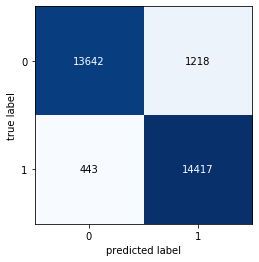

In [84]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

model = MultinomialNB()

model.fit(X=tf_train,y=y_train)
expected = y_test
predicted=model.predict(tf_test)
print(metrics.classification_report(expected, predicted))
#print(metrics.confusion_matrix(expected, predicted))

from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(metrics.confusion_matrix(expected, predicted))